# NCTU Introduction to Machine Learning, Final Project
Ensemble model (LR + LightGBM + Catboost)

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, HuberRegressor
from sklearn.impute import KNNImputer
from feature_engine.encoding import WoEEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import pickle
import warnings; warnings.filterwarnings("ignore")

## 1. Read from csv

In [2]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
sub = pd.read_csv("./sample_submission.csv")

## 2. Checking Missing values
* Count missing values in df_train and df_test


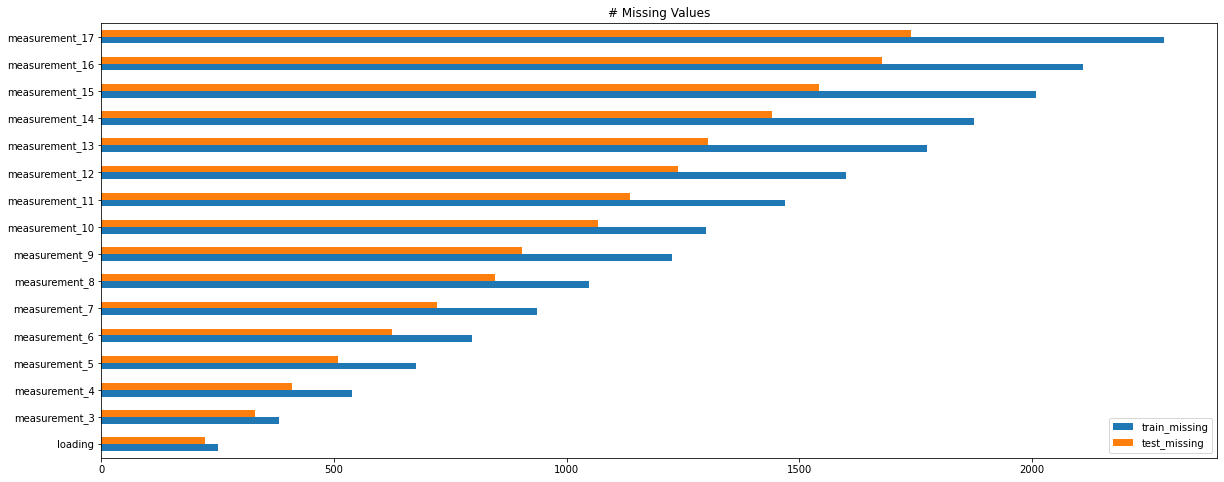

In [3]:
train = df_train.copy()
test = df_test.copy()
ncounts = pd.DataFrame([train.isna().sum(), test.isna().sum()]).T
ncounts = ncounts.rename(columns={0: "train_missing", 1: "test_missing"})

ncounts.query("train_missing > 0").plot(
    kind="barh", figsize=(20, 8), title="# Missing Values"
)
plt.show()

* Observe relationship between missing data

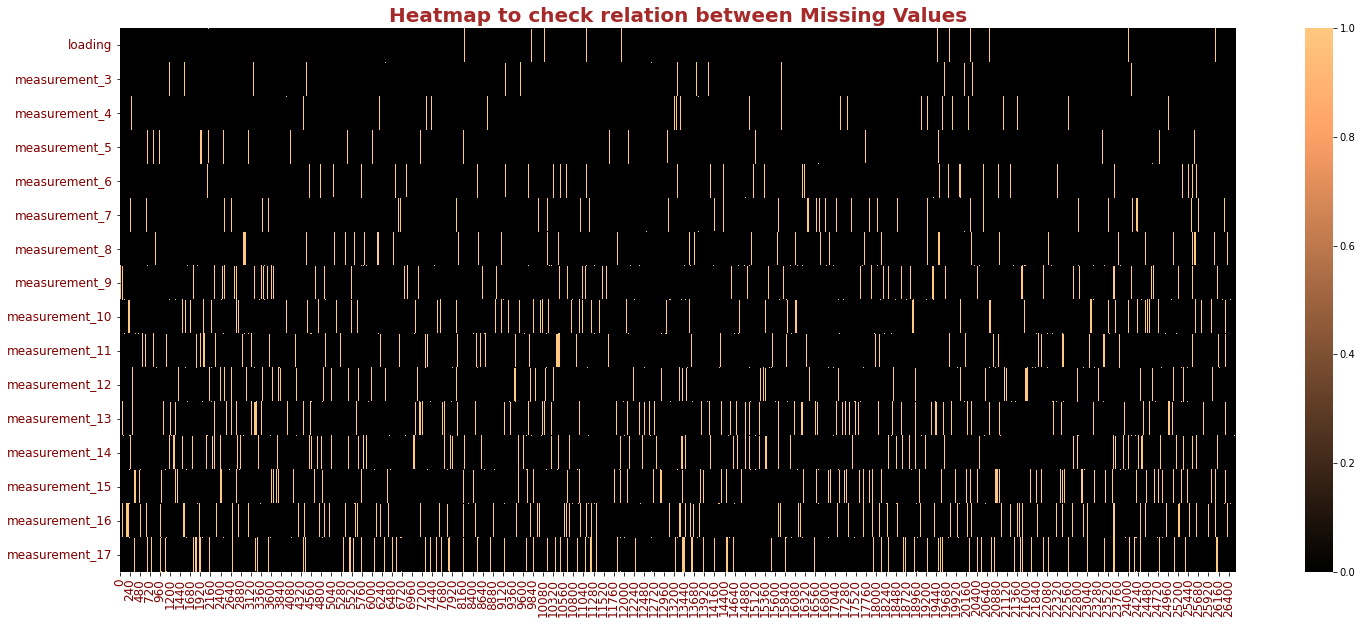

In [4]:
plt.figure(figsize=(25,10))
sns.heatmap(df_train[df_train.columns[df_train.isna().any()]].isna().transpose(), cmap="copper")
plt.title('Heatmap to check relation between Missing Values', weight = 'bold', size = 20, color = 'brown')
plt.xticks(size = 12, color = 'maroon')
plt.yticks(size = 12, color = 'maroon')
plt.show()

* Observe missing values grouping by product code 

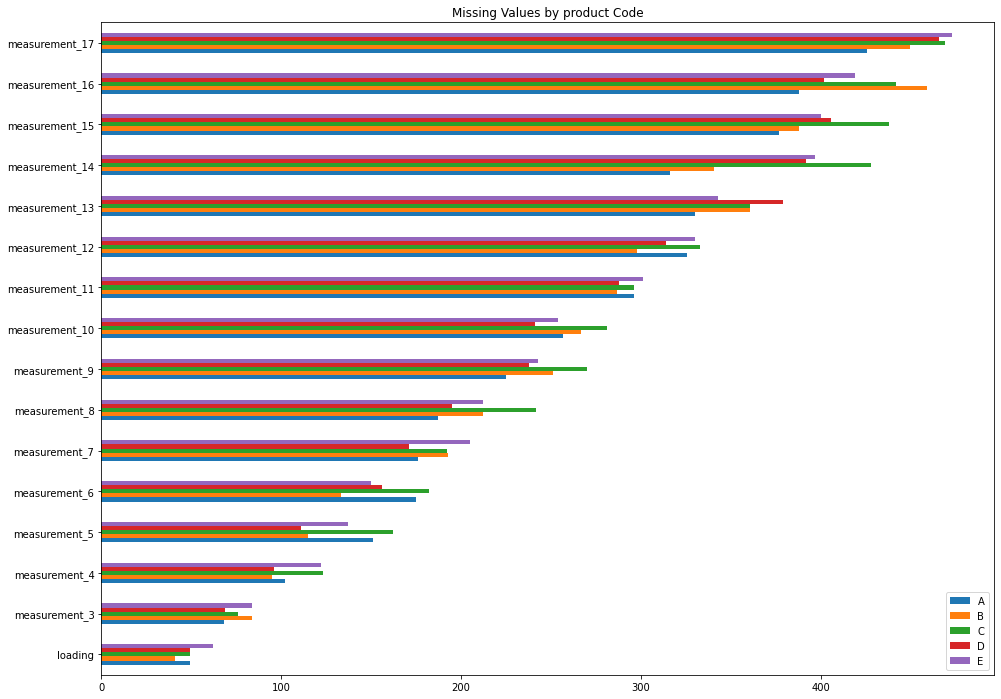

In [5]:
pro_code = df_train.product_code.unique()
comp = pd.DataFrame([df_train[df_train.product_code == i].isna().sum() for i in pro_code]).T
comp.columns = pro_code
comp.query('A>0').plot(
    kind="barh", figsize=(16, 12), title="Missing Values by product Code"
)
plt.show()

In [6]:
target = df_train['failure']            
groups = df_train['product_code']
df_train.drop('failure', axis=1, inplace=True)

## 3. Data processing

In [7]:
def preprocessing(df_train, df_test):

    data = pd.concat([df_train, df_test])
    data['m3_missing'] = data['measurement_3'].isnull().astype(np.int8)
    data['m5_missing'] = data['measurement_5'].isnull().astype(np.int8)
    data['area'] = data['attribute_2'] * data['attribute_3']
    feature = [f for f in df_test.columns if f.startswith('measurement') or f == 'loading']


    # 1. dictionnary of dictionnaries (for the 11 best correlated measurement columns)
    # select the best correlated columns according to the product code
    full_fill_dict ={}


    # 2. Make a manual selection for measurement_17
    full_fill_dict['measurement_17'] = {
        'A': ['measurement_5','measurement_6','measurement_8'],
        'B': ['measurement_4','measurement_5','measurement_7'],
        'C': ['measurement_5','measurement_7','measurement_8','measurement_9'],
        'D': ['measurement_5','measurement_6','measurement_7','measurement_8'],
        'E': ['measurement_4','measurement_5','measurement_6','measurement_8'],
        'F': ['measurement_4','measurement_5','measurement_6','measurement_7'],
        'G': ['measurement_4','measurement_6','measurement_8','measurement_9'],
        'H': ['measurement_4','measurement_5','measurement_7','measurement_8','measurement_9'],
        'I': ['measurement_3','measurement_7','measurement_8']
    }


    # 3. Collect the next 10 best measurement columns sorted by correlation
    col_not_use = [col for col in df_test.columns if 'measurement' not in col]+ ['loading','m3_missing','m5_missing']  #//columns to be dropped
    a = []
    b = []
    for x in range(3,17):
        corr = np.absolute(data.drop(col_not_use, axis=1).corr()[f'measurement_{x}']).sort_values(ascending=False)
        a.append(np.round(np.sum(corr[1:4]),3)) # sum the 3 highest correlation values
        b.append(f'measurement_{x}')
        # print(corr)
        # print(a, "\n", b)
    c = pd.DataFrame()
    c['Selected columns'] = b
    c['correlation total'] = a
    c = c.sort_values(by = 'correlation total',ascending=False).reset_index(drop = True)
    print(f'Columns selected by correlation sum of the 3 first rows : ')
    display(c.head(10)) #choose the first 10 best correlated
    

    # 4. For the first 10 best correlated features and for each unique product_code, append to dict
    for i in range(10): 
        measurement_col = 'measurement_' + c.iloc[i,0][12:]  
        fill_dict = {}
        for x in data.product_code.unique() : 
            corr = np.absolute(data[data.product_code == x].drop(col_not_use, axis=1).corr()[measurement_col]).sort_values(ascending=False)
            measurement_col_dic = {}
            measurement_col_dic[measurement_col] = corr[1:5].index.tolist() # choose 4 highest correlation values
            fill_dict[x] = measurement_col_dic[measurement_col]
        full_fill_dict[measurement_col] = fill_dict  # got a dict of 11 best correlated measurement columns
    

    # 5. Missing value imputing group by unique product_code
    feature = [f for f in data.columns if f.startswith('measurement') or f == 'loading']
    nullValue_cols = [col for col in df_train.columns if df_train[col].isnull().sum() != 0]
    for code in data.product_code.unique():
        total_na_filled_by_linear_model = 0
        print(f'\n-------- Product code {code} ----------\n')
        print(f'filled by linear model :')

        # 5-1. Filled with Linear model (HuberRegressor)
        for measurement_col in list(full_fill_dict.keys()):
            tmp = data[data.product_code == code]
            column = full_fill_dict[measurement_col][code]
            tmp_train = tmp[column+[measurement_col]].dropna(how='any')
            tmp_test = tmp[(tmp[column].isnull().sum(axis=1)==0)&(tmp[measurement_col].isnull())]

            model = HuberRegressor(epsilon=1.9)
            model.fit(tmp_train[column], tmp_train[measurement_col])
            data.loc[(data.product_code == code) & (data[column].isnull().sum(axis=1) == 0) & (data[measurement_col].isnull()),measurement_col] = model.predict(tmp_test[column])
            print(f'{measurement_col} : {len(tmp_test)}')
            total_na_filled_by_linear_model += len(tmp_test)

        # 5-2. Filled with KNN for others NA columns
        NA = data.loc[data["product_code"] == code,nullValue_cols ].isnull().sum().sum()
        model1 = KNNImputer(n_neighbors=3)
        data.loc[data.product_code == code, feature] = model1.fit_transform(data.loc[data.product_code == code, feature])
        print(f'\n{total_na_filled_by_linear_model} filled by linear model ') 
        print(f'{NA} filled by KNN ')

    
    # 6. Add the measurement_avg feature
    data['measurement_avg'] = data[[f'measurement_{i}' for i in range(3, 17)]].mean(axis=1)
    df_train = data.iloc[:df_train.shape[0],:]
    df_test = data.iloc[df_train.shape[0]:,:]


    # 7. Extract the WoEEncoder feature
    woe_encoder = WoEEncoder(variables=['attribute_0'])
    woe_encoder.fit(df_train, target)
    df_train = woe_encoder.transform(df_train)
    df_test = woe_encoder.transform(df_test)


    # 8. Features chosen
    features = ['loading', 'attribute_0', 'measurement_17', 
                'measurement_0', 'measurement_1', 'measurement_2', 
                'area', 'm3_missing', 'm5_missing', 'measurement_avg']


    return df_train, df_test, features


def scale(train_data, val_data, test_data, feats):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(train_data[feats])
    scaled_val = scaler.transform(val_data[feats])
    scaled_test = scaler.transform(test_data[feats])
    new_train = train_data.copy()
    new_val = val_data.copy()
    new_test = test_data.copy()
    new_train[feats] = scaled_train
    new_val[feats] = scaled_val
    new_test[feats] = scaled_test
    return new_train, new_val, new_test

In [8]:
df_train, df_test, features = preprocessing(df_train, df_test)
df_train['failure'] = target
x_train, x_val, x_test = scale(
    df_train[features], df_train[features], df_test[features], features)
    
x_train.to_csv("x_train.csv", index=False)
x_test.to_csv("x_test.csv", index=False)

Columns selected by correlation sum of the 3 first rows : 


,Selected columns,correlation total
0,measurement_8,0.448
1,measurement_11,0.395
2,measurement_5,0.376
3,measurement_6,0.359
4,measurement_7,0.330
5,measurement_4,0.328
6,measurement_15,0.301
7,measurement_10,0.300
8,measurement_16,0.252
9,measurement_14,0.225



-------- Product code A ----------

filled by linear model :
measurement_17 : 386
measurement_8 : 167
measurement_11 : 225
measurement_5 : 113
measurement_6 : 146
measurement_7 : 153
measurement_4 : 79
measurement_15 : 273
measurement_10 : 209
measurement_16 : 293
measurement_14 : 237

2281 filled by linear model 
1568 filled by KNN 

-------- Product code B ----------

filled by linear model :
measurement_17 : 418
measurement_8 : 165
measurement_11 : 220
measurement_5 : 83
measurement_6 : 106
measurement_7 : 174
measurement_4 : 80
measurement_15 : 294
measurement_10 : 197
measurement_16 : 358
measurement_14 : 330

2425 filled by linear model 
1550 filled by KNN 

-------- Product code C ----------

filled by linear model :
measurement_17 : 391
measurement_8 : 189
measurement_11 : 231
measurement_5 : 141
measurement_6 : 150
measurement_7 : 140
measurement_4 : 108
measurement_15 : 319
measurement_10 : 262
measurement_16 : 343
measurement_14 : 330

2604 filled by linear model 
1740 fill

## 4. Train the model


### Logistic Regression


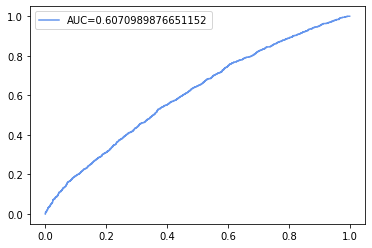

In [9]:

X_train, X_val, y_train, y_val = train_test_split(x_train,target,test_size=0.2, random_state=13)
clf1 = LogisticRegression(max_iter=1000, C=0.001, penalty='l2', solver='newton-cg')
clf1.fit(X_train,y_train)
pickle.dump(clf1, open('model1.pkl', 'wb'))

prediction = clf1.predict_proba(X_val)[::,1]
fpr, tpr, _ = roc_curve(y_val,  prediction)
auc = roc_auc_score(y_val, prediction)
plt.plot(fpr, tpr, label="AUC="+str(auc), color='cornflowerblue')
plt.legend(loc=2)
plt.show()

### LightGBM model

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] num_iterations is set=70, num_boost_round=70 will be ignored. Current value: num_iterations=70


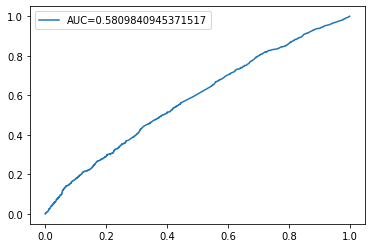

In [10]:
X_train, X_val, y_train, y_val = train_test_split(x_train,target,test_size=0.2, random_state=42)
clf2 = lgb.LGBMClassifier(**{'seed': 42, 'n_jobs': -1, 'lambda_l2': 2, 'metric': "auc", 'max_depth': -1, 
                          'boosting': 'gbdt', 'bagging_freq': 10, 'learning_rate': 0.008,
                          'objective': 'binary','num_boost_round': 70,'verbose_eval':-1})
clf2.fit(X_train,y_train,eval_set=(X_val,y_val),verbose=False)
pickle.dump(clf2, open('model2.pkl', 'wb'))

prediction = clf2.predict_proba(X_val)[::,1]
fpr, tpr, _ = roc_curve(y_val,  prediction)
auc = roc_auc_score(y_val, prediction)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=2)
plt.show()

### CatBoost Gradient Boosting

0:	test: 0.5621750	best: 0.5621750 (0)	total: 163ms	remaining: 2m 43s
100:	test: 0.5916742	best: 0.5916742 (100)	total: 2.67s	remaining: 23.8s
200:	test: 0.5915341	best: 0.5916742 (100)	total: 5.18s	remaining: 20.6s
300:	test: 0.5923780	best: 0.5923780 (300)	total: 8.8s	remaining: 20.4s
400:	test: 0.5928198	best: 0.5928198 (400)	total: 12.6s	remaining: 18.8s
500:	test: 0.5928405	best: 0.5928405 (500)	total: 16.4s	remaining: 16.3s
600:	test: 0.5930727	best: 0.5930727 (600)	total: 19.9s	remaining: 13.2s
700:	test: 0.5932578	best: 0.5932578 (700)	total: 23s	remaining: 9.82s
800:	test: 0.5934247	best: 0.5934247 (800)	total: 26.3s	remaining: 6.53s
900:	test: 0.5930760	best: 0.5934247 (800)	total: 29.5s	remaining: 3.24s
999:	test: 0.5931020	best: 0.5934247 (800)	total: 32.5s	remaining: 0us

bestTest = 0.5934247316
bestIteration = 800

Shrink model to first 801 iterations.


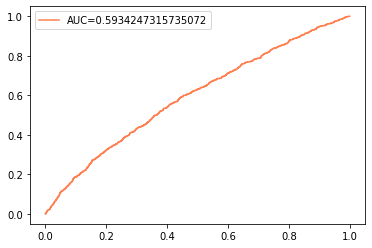

In [11]:
X_train, X_val, y_train, y_val = train_test_split(x_train,target,test_size=0.2, random_state=42)
clf3 = CatBoostClassifier(metric_period = 100, eval_metric='AUC',verbose=1,
                        l2_leaf_reg=2,depth=3,learning_rate=0.02, use_best_model=True)
clf3.fit(X_train,y_train,eval_set=(X_val,y_val),verbose=True)
pickle.dump(clf3, open('model3.pkl', 'wb'))

prediction = clf3.predict_proba(X_val)[::,1]
fpr, tpr, _ = roc_curve(y_val,  prediction)
auc = roc_auc_score(y_val, prediction)
plt.plot(fpr,tpr,label="AUC="+str(auc), color='coral')
plt.legend(loc=2)
plt.show()

## 5. Ensemble model

In [12]:
testData = pd.read_csv('./test.csv')
submitData = pd.read_csv('./sample_submission.csv')
prediction1 = clf1.predict_proba(x_test)[:,1] * 0.8
prediction2 = clf2.predict_proba(x_test)[:,1] * 0.1
prediction3 = clf3.predict_proba(x_test)[:,1] * 0.1
prediction = prediction1 + prediction2 + prediction3

## 6. Testing

In [13]:
output = pd.DataFrame({'id': submitData.id, 'failure': prediction})
output.to_csv('submission.csv', index=False)